In [1]:
import numpy as np
import optimizers
import measures
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
X, y = make_moons()

In [2]:
class LogisticRegression:
    def __init__(self, optimization, **kwargs):
        self.optimization = optimization
        self.kwargs=kwargs
        self.losses = None
        self.is_trained = False
        self.__is_optimization_known(optimization)
        if optimization == 'Gradient Descent':
            self.__optimizer = optimizers.GradientDescent(**self.kwargs)
        elif optimization == 'Stochastic Gradient Descent':
            self.kwargs['batch_size'] = 1
            self.__optimizer = optimizers.GradientDescent(**self.kwargs)
        elif optimization == 'Iterative Reweighted Least Squares':
            self.__optimizer = optimizers.IRLS(**self.kwargs)
        elif optimization == 'Adaptive Moment Estimation':
            self.__optimizer = optimizers.ADAM(**self.kwargs)
            
    @staticmethod
    def __is_optimization_known(o):
        if o not in ['Gradient Descent', 'Stochastic Gradient Descent',
                     'Iterative Reweighted Least Squares', 'Adaptive Moment Estimation']:
            raise ValueError(f'Unknown optimization {o}')

    def train(self, X, y):
        #todo: check the dimensions?
        self.__optimizer.train(X, y)
        
    def predict(self, X):
        return self.__optimizer.predict(X)
    
    def get_optimizer_training_losses(self):
        return self.__optimizer.losses
    def get_optimizer_training_w(self):
        return self.__optimizer.w

In [3]:
lr_gd = LogisticRegression(optimization='Gradient Descent', learning_rate=0.01, epochs=50, batch_size=10)

In [4]:
lr_gd.train(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
lr_sgd = LogisticRegression(optimization='Stochastic Gradient Descent', learning_rate=0.01, epochs=50)

In [6]:
lr_sgd.train(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
lr_irls = LogisticRegression(optimization='Iterative Reweighted Least Squares', epochs=50)
lr_irls.train(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
lr_adam = LogisticRegression(optimization='Adaptive Moment Estimation',
                             epochs=50,
                             learning_rate=0.01,
                             beta_1=0.9,
                             beta_2=0.99,
                             epsilon=1e-8
                            )
lr_adam.train(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

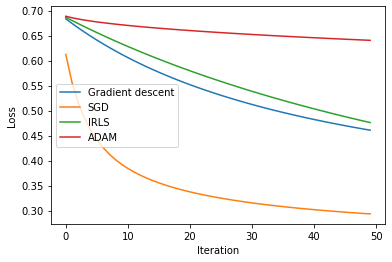

In [9]:
l_gd = lr_gd.get_optimizer_training_losses()
l_sgd = lr_sgd.get_optimizer_training_losses()
l_irls=lr_irls.get_optimizer_training_losses()
l_adam=lr_adam.get_optimizer_training_losses()
plt.plot(range(len(l_gd)), l_gd, label='Gradient descent')
plt.plot(range(len(l_sgd)), l_sgd, label='SGD')
plt.plot(range(len(l_irls)), l_irls, label='IRLS')
plt.plot(range(len(l_adam)), l_adam, label='ADAM')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [10]:
p_gd = lr_gd.predict(X)
p_sgd = lr_sgd.predict(X)
p_irls=lr_irls.predict(X)
p_adam=lr_adam.predict(X)

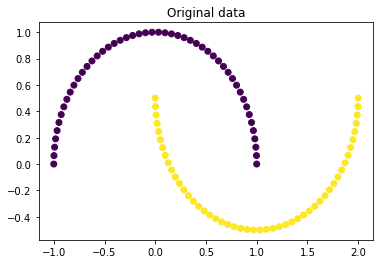

In [11]:
plt.scatter(*X.T, c=y)
plt.title('Original data')
plt.show()

accuracy:  0.8


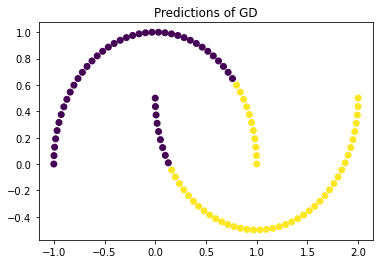

In [12]:
print("accuracy: ",np.mean(p_gd==y))
plt.scatter(*X.T, c=p_gd)
plt.title('Predictions of GD')
plt.show()

accuracy:  0.85


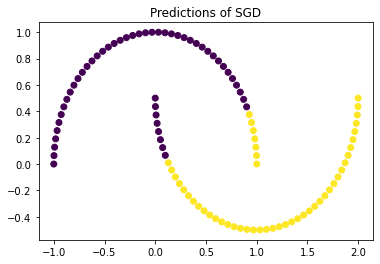

In [13]:
print("accuracy: ",np.mean(p_sgd==y))
plt.scatter(*X.T, c=p_sgd)
plt.title('Predictions of SGD')
plt.show()

accuracy:  0.88


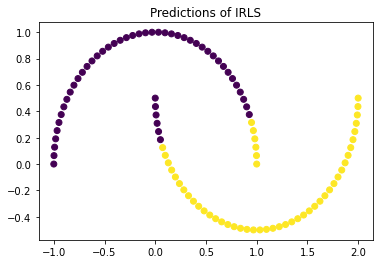

In [14]:
print("accuracy: ",np.mean(p_irls==y))
plt.scatter(*X.T, c=p_irls)
plt.title('Predictions of IRLS')
plt.show()

accuracy:  0.8


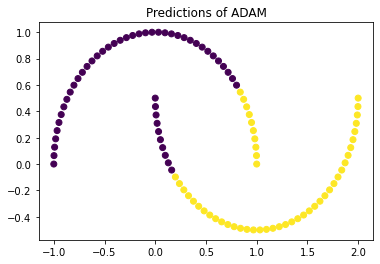

In [15]:
print("accuracy: ",np.mean(p_adam==y))
plt.scatter(*X.T, c=p_adam)
plt.title('Predictions of ADAM')
plt.show()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder ### available? Imho should be, like cmon
from sklearn.model_selection import train_test_split ###hopefully we're allowed to use this too
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        print(X.shape[1]," features left in dataset")
        return X

In [17]:
from scipy.io import arff
import pandas as pd
data = arff.loadarff('data/messidor_features.arff')
retinopathy_df = pd.DataFrame(data[0])
retinopathy_df.head()
retinopathy_df.drop(columns='Class',inplace=True)
X_retinopathy=retinopathy_df.drop(columns='18')
y_retinopathy=retinopathy_df['18']

In [18]:
Mult_Coll = ReduceVIF()

X_retinopathy_clean = Mult_Coll.fit_transform(X_retinopathy)
X_train, X_test, y_train, y_test=train_test_split(X_retinopathy_clean.to_numpy(dtype="float64"),y_retinopathy.to_numpy(dtype="int32"),test_size=0.2)

model = LogisticRegression(optimization='Adaptive Moment Estimation',
                             epochs=5000,
                             learning_rate=0.01,
                             beta_1=0.9,
                             beta_2=0.99,
                             epsilon=1e-8
                            )
model.train(X_train, y_train)
print(X_train.shape[1])
p_adam=model.predict(X_test)
np.mean(p_adam==y_test)

ReduceVIF fit
ReduceVIF transform
Dropping 3 with vif=1581.0934506404067
Dropping 4 with vif=1013.2184999946357
Dropping 5 with vif=505.7542232451138
Dropping 0 with vif=176.39934069845557
Dropping 6 with vif=160.2805523420387
Dropping 16 with vif=46.294584151547134
Dropping 10 with vif=30.634827572575794
Dropping 14 with vif=30.18259042842544
Dropping 13 with vif=15.917338849843683
Dropping 2 with vif=14.931098433533888
Dropping 17 with vif=10.790655819462563
Dropping 11 with vif=9.026524702684425
Dropping 8 with vif=5.758637535010778
5  features left in dataset


  0%|          | 0/5000 [00:00<?, ?it/s]

Early stopping
5


0.7445887445887446

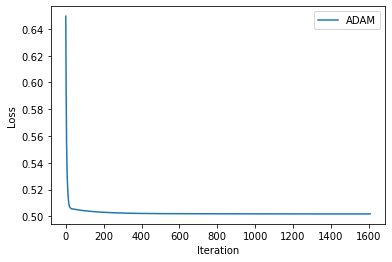

In [19]:
l_adam=model.get_optimizer_training_losses()

plt.plot(range(len(l_adam)), l_adam, label='ADAM')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()